# Practical 4: Reinforcement Learning

## Introduction
In this practical we introduce the idea of reinforcement learning, discuss how it differs from supervised and unsupervised learning and then build an agent that learns to play a simple game called "Catcher".

## Learning Objectives
* Understand the relationship between the **environment** and the  **agent**  
* Understand how a **policy** is used by an agent to select an action
* Describe how to implement a **run-loop** that controls the interaction between environement and agent.
* Understand how the **state**, **action** and **reward** are communicated between the agent and the environment.  
* Be able to implement the a simple **policy-gradient** RL algorithm call **REINFORCE**
* Discover at least one potential issue with the REINFORCE algorithm.

In [51]:
#@title [RUN ME!] Install pre-requisites. { display-mode: "form" }
import os
import sys
import math	

!git clone https://github.com/ntasfi/PyGame-Learning-Environment.git
os.chdir('PyGame-Learning-Environment')
!pip -q install -e .
!pip -q install pygame
#os.chdir('/content')

sys.path.append('PyGame-Learning-Environment')
os.environ["SDL_VIDEODRIVER"] = "dummy"  # prevent trying to open a window

!pip -q install moviepy

print('Installed pre-requisites...')

fatal: destination path 'PyGame-Learning-Environment' already exists and is not an empty directory.
Installed pre-requisites...


In [52]:
#@title [RUN ME!] Imports { display-mode: "form" }

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import os
#pip install moviepy
import moviepy.editor as mpy
from ple import PLE
from ple.games import pong
from ple.games import pixelcopter
from ple.games import flappybird
from ple.games import catcher
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import seaborn as sns

import tensorflow as tf
try:
  tf.enable_eager_execution()
  print('Running Eagerly')
except ValueError:
  print('Already running Eagerly')

Running Eagerly


In [53]:
#@title [RUN ME!] Helper Functions { display-mode: "form" }

def make_animation(images, fps=60, true_image=False):
  duration = len(images) / fps

  def make_frame(t):
    try:
      x = images[int(len(images) / duration * t)]
    except:
      x = images[-1]

    if true_image:
      return x.astype(np.uint8)
    else:
      return ((x + 1) / 2 * 255).astype(np.uint8)

  clip = mpy.VideoClip(make_frame, duration=duration)
  clip.fps = fps
  return clip

def progress(value, max=100, message=''):
  return display.HTML("""
      <progress
          value='{value}'
          max='{max}',
          style='width: 100%'
      >
          {value}
      </progress>
      <p>{message}</p>
  """.format(value=value, max=max, message=message))

def plot_rolling_returns(rolling_returns):  
  sns.tsplot(rolling_returns)
  plt.title('Rolling Returns')
  plt.xlabel('# Epsiodes')
  plt.ylabel('Rolling Return')
  
def state_to_buckets(state, bucket_width=0.25):
  return tuple(math.ceil(s / bucket_width)-1 for s in state)

## Reinforcement Learning
So far we have encountered **supervised learning**, where we have an input and a target value or class that we want to predict. We have also encountered **unsupervised learning** where we are only given an input and look for patterns in that input. In this practical, we look into **reinforcement learning** which can loosely be defined as training an **agent** to maximise a numerical **reward** it obtains through interaction with an **environment**. 

The environment defines a set of **actions** that an agent can take. The agent observes the current **state** of the environment, tries actions and *learns* a **policy** which is a distribution over the possible actions given a state of the environment. 

The following diagram illustrates the interaction between the agent and environment. We will explore each of the terms in more detail throughout this practical. 


![Interaction of Agent and Environment](https://github.com/deep-learning-indaba/indaba-2018/blob/master/images/rl_diagram1.png?raw=true)


## Outline
We will train an agent to play a very simple game called "Catcher" which is often used as a test bed for RL algorithms. In the process we will set up all the necessary framework to explore variations of the algorithm or switch to more advanced games! In particular, the steps we will follow in this practical are as follows:

1. Introduce the game environment, explore the states and actions available. 
2. Create a simple agent that takes random actions
3. Write a run-loop which controls the interaction and manages the communication between the agent and environment
4. Implement a policy as a feed-forward neural network
5. Explain and implement the REINFORCE algorithm to learn how to play the game

## The Environment
The environment we consider is the **game Catcher from the PyGame Learning Environment (PLE) library.** The player (agent) controls a paddle that it must use to catch a falling fruit. Each time the game runs, the fruit falls from from the top to the bottom of the screen, starting at a different X coordinate (which doesn't change during the episode) and the paddle starts in a random location along the bottom of the screen. The player wins if they manage to catch the fruit and loses if it falls to the ground. 

![Catcher game illustration](https://pygame-learning-environment.readthedocs.io/en/latest/_images/catcher.gif)

### Create the environment using PLE
For this game, we'll set things up so that the reward will be non-zero only at the end of each episode, and will be +1 for catching the fruit and -1 for missing it. For all other frames the reward will be zero.

**Note**: PLE has a number of games, which it wraps in a generic "environment". 
So, in this case, both ```evironment``` and ```game``` constitute our environment. ```environment``` allows us to perform actions 
and returns states and rewards, while ```game``` handles the specifics of Catcher (or whichever other game we decide to use)

In [54]:
# Create an instance of the catcher game
game = catcher.Catcher(init_lives=1)
game_height = game.height
game_width = game.width

frame_skip = 3  # Skip 3 frames at each step to speed up the game

# Wrap the game in a PLE environment and configure the rewards
environment = PLE(game, display_screen=False, force_fps=True, 
                  reward_values={'win': 1.0, 'loss': -1.0, 'negative': 0.0}, 
                  frame_skip=frame_skip)  

# The reward_values dictionary above allows us to override the default reward structure provided by PLE. 
# win and loss specify the rewards for winning or losing an episode, while positive and negative 
# specify the rewards received for positive or negative events that can occur during the game.
# If you change the game, start by *removing* the overrides and see what the default is before deciding if
# you want to modify it. 

# Initialise the environment
environment.init()

### What does the state look like?
The environment provides a rendering of the virtual 'screen' of the game to an RGB image, by using the method ```getScreenRGB```. For this practical, in the interests of simplicity and quick trianing time, we use the *game state* directly, which provides a summary (in a dictionary) of important peices of information making up the current state of the game. 

In [55]:
print('Current game state:', game.getGameState())

Current game state: {'player_x': 25, 'fruit_x': 8, 'player_vel': 0.0, 'fruit_y': -8}


### What actions are available?
The following cell prints the actions that are available in the current game, which are represented with numerical codes. The PLE environment wrapper also adds an additional ```None``` action which means "do nothing". 

In [56]:
print('Game actions:', game.actions)
print('Environment actions:', environment.getActionSet())

Game actions: {'right': 100, 'left': 97}
Environment actions: [100, 97, None]


In [57]:
#@title [RUN ME!] Setup for the next section { display-mode: "form" }
# Maintain some variables for the next task
environment.reset_game()
observed_states = []
observed_actions = []
observed_rewards = []
observed_states.append(game.getGameState())

### Exploratory Task
Run the cell below which defines a function that takes a given action in the environment, using the environment's ```act``` method and then renders both the previous and current game screen. Change the action in the drop-down to the right of the 2nd code cell, which calls this function with the chosen action. Observe what happens to the environment(game) state and reward. By running the cell multiple times (and changing the action) until the game comes to an end (when you either win or lose), you will manually create an **episode**, which is a sequence of states, actions and rewards until a termination condition is reached. If an episode $i$ consists of $T_i$ steps and we denote the state, action and reward at step $t$ in episode $i$ respectively as $s_{i, t}$, $a_{i,t}$ and $r_{i,t}$, then in this task, we create a *trajectory* $\tau_i = (s_{i, 1}, a_{i, 1}, r_{i, 1}, ..., a_{i, T_i-1}, r_{i, T_i-1}, s_{i, T_i})$

#### Question
Notice how the paddle sometimes moves even if you take the "None" action? Can you think of why this happens? 

#### Notes
* If you want to run another episode, re-run the code cell above titled "Setup for the next section" to reset the environment
* This particular game returns a reward of $0$ at each step and a final reward of $-1$ or $1$ at the end of the episode depending on whether you lose or win. Other games may have different reward structures! 

In [58]:
previous_frame = environment.getScreenRGB().transpose([1, 0, 2])

def take_action(action):
  global previous_frame
  
  # Look up the action code from the description
  action_code = None if action == 'None' else game.actions[action]

  # Take the selected action in the environment
  print('Taking action: {} ({})'.format(action, action_code))
  reward = environment.act(action_code)

  observed_actions.append(action)
  observed_rewards.append(reward)

  # Print and display the current state and reward
  state = game.getGameState()
  print('Game state:', state)
  print('Reward received: ', reward)

  observed_states.append(state)

  if reward > 0 or environment.game_over():
    print('Game over, you', 'WON' if reward > 0 else 'LOST')
    print('The episode trajectory was:')
    for s, a, r in zip(observed_states, observed_actions, observed_rewards):
      print('State:', s, 'Action:', a, 'Reward:', r)
    print('Terminal state:', observed_states[-1])
  
  current_frame = environment.getScreenRGB().transpose([1, 0, 2])
  
  fig = plt.figure(figsize=(10, 20))
    
  ax = plt.subplot(1, 2, 1)
  plt.imshow(previous_frame)
  ax.grid(False)
  ax.set_title('PREVIOUS FRAME')
  
  ax = plt.subplot(1, 2, 2)
  plt.imshow(current_frame)
  ax.grid(False)
  ax.set_title('CURRENT FRAME')
  
  previous_frame = current_frame

Taking action: None (None)
Game state: {'player_x': 25, 'fruit_x': 12, 'player_vel': 0.0, 'fruit_y': 0}
Reward received:  0.0


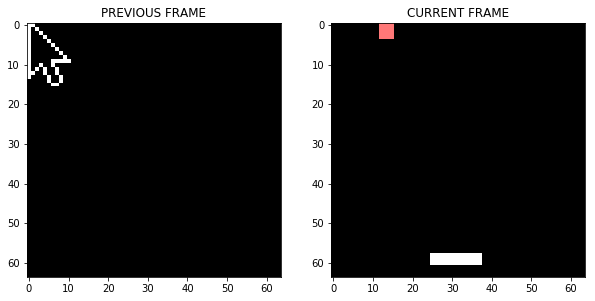

In [59]:
action = "None"  #@param ['right', 'left', 'None']
take_action(action)

## The Agent
We now turn to the agent. An agent receives the current state and (previous) reward from the environment, then uses an internal policy to determine an action to take. We implement an agent as a Python [**class**](https://en.wikibooks.org/wiki/A_Beginner%27s_Python_Tutorial/Classes), which is just a logical wrapper of variables and methods (functions) that operate on those variables. The methods our agent will have are the following:

* **Initialisation** (```__init__```):  Initialises the agent the first time it's created. 
* **policy**: The policy is a function that returns a *distribution* over the possible actions, given the current state.
* **step**: This takes as input, the current state and previous reward from the environment, then uses the internal policy to determine which action to take. Specifically, it does some pre-processing of the state, then samples a single action from the distribution over possible actions obtained from the policy. 
* **reset**: This is called to reset the agent's variables before running it on a new episode
* **end_episode**: This method signals to the agent that the current episode has come to an end. The agent may do some learning, or clean-up at the end of an episode. 

### The Random Agent

To get a feel for an agent and the methods it has, we implement an agent that just takes a *random* action at every step. For demonstration purposes, we also calculate the **episode return** at the end of an episode. The episode return is the sum of the (discounted) rewards obtained during the episode. If the returns for episode $i$, with trajectory $\tau_{i}$ are denoted $r_{i, t}$, and the **discount factor** is $\gamma$, then the episode return is calcuated as: $r(\tau_i) = \sum_{t=1}^{T_i} \gamma^t r_{i,t}$. The discount factor allows us to increase the importance of rewards received quickly and decrease the importance of rewards that take long to receive. It is especially important in environments that could have episodes that are infinitely long. In our particular environment where every episode is of the same length and the only non-zero reward is received at the end of the game, the discount factor doesn't make much difference and so we will ignore it (effectively set it to $1$) for the remainder of this practical. 

In [60]:
class RandomAgent(object):
  
  def __init__(self, actions, state_size, seed):
    # When initializing, we let the agent know what actions are available in the 
    # environment, how large the state is (not used in the RandomAgent) and the 
    # current seed to use (also not used in the RandomAgent)
    self._actions = actions
    self._rewards = []
    self._taken_actions = []
    self._observed_states = []
 
  def policy(self, state):  
    # The policy is an internal function that takes a state and returns a distribution over the possible actions. 
    # The random agent just returns a uniform distribution over the actions. 
    n = len(self._actions)  # The number of actions
    return tf.fill([n], 1./n)  # This returns a vector of length n, with each entry being 1/n
    
  def step(self, state_dict, reward):
    
    # Pre-process the state to extract the numerical values we're interested in from the state dictionary
    state = np.array([
        state_dict['fruit_x'] / game_width,  # Divide by width(or height) to normalise the value to lie between 0 and 1.
        state_dict['player_x'] / game_width,
        state_dict['fruit_y'] / (game_height+1),
        state_dict['player_vel'] / game_width
    ], dtype=np.float32)
    
    self._observed_states.append(state)  # Record that the state was observed during the episode
    self._rewards.append(reward)  # Keep track of the rewards we've received along the way
    action_distribution = self.policy(state)  # Use the policy to get the distribution over actions
    
    # Sample a single action according to the distribution over actions
    action = np.random.choice(self._actions, p=action_distribution.numpy())  
    
    self._taken_actions.append(action)  # Record that the action was taken during the episode
    
    return action
  
  def reset(self):
    # This method is called when a new episode starts, we need to clear the 
    # states, actions and rewards that we tracked during the last episode.
    self._rewards = [] 
    self._taken_actions = []  
    self._observed_states = []  
    
  def end_episode(self, final_reward):
    # We just calculate the episode return
    episode_return = sum(self._rewards) + final_reward
    return episode_return

## The Run-Loop
Now that we have an environment and a simple agent, we need a way of controlling the interaction between the agent and environment over multiple episodes. We do so in a **run-loop**. In this simple run-loop, the agent and environment run in lock-step. For each game frame, we get the state from the environment and pass it, along with the previous reward, to the agent. The agent selects an action that it wants to take given the game state. The action is taken in the environment and any reward received is recorded. We run the loop for multiple episodes, each time being careful to reset the game and agent (because they're starting a new game from scratch).

In [ ]:
def run_loop(agent_class,                    # Which agent to use
             num_episodes=1,                 # How many episodes to run for
             record_every=1,                 # How many episodes to record
             seed=1234,                      # The random seed used
             rolling_return_frequency=100,   # The window size used to track the rolling episode return
             state_size=4):                  # The size of the state
  
  # Set the random seeds
  tf.set_random_seed(seed)
  np.random.seed(seed)
  
  # Initialise the environment
  environment.init()
  
  # Create an agent (this runs the agent's __init__ method)
  agent = agent_class(environment.getActionSet(), state_size, seed)
  
  progress_out = display.display(progress(0, num_episodes), display_id=True)  # Create a progress-bar
  
  # Create data structures to store metrics
  windowed_return = deque()
  rolling_returns = []
  frames = []
  
  for episode in range(num_episodes):
    environment.reset_game() # reset the environment
    agent.reset()  # reset the agent
    reward = 0

    while reward == 0 and not environment.game_over():   # Loop until the episode terminates      
      state = game.getGameState()  # Get the current game state
      action = agent.step(state, reward)  # Pass the current game state and previous reward to the agent, get the action it wants to take
      reward = environment.act(action)  # Pass the action to the environment and get the reward.

      if episode % record_every == 0:
        # Store the frames for display later, every `record_every` episodes
        frames.append(environment.getScreenRGB())
    
    info = agent.end_episode(reward)  # Signal to the agent that the episode has come to and end
    
    # Store the episode return in the window (in this case, with no discounting, the episode return is the same as the environment's score)
    windowed_return.append(environment.score())
    if len(windowed_return) > rolling_return_frequency:
      windowed_return.popleft()
    
    rolling_return = sum(windowed_return) / len(windowed_return)
    rolling_returns.append(rolling_return)
    
    # Update the progress-bar
    message = 'Episode {}/{} ended with score {}, Rolling Return: {}, {}'.format(
        episode+1, num_episodes, environment.score(), 
        rolling_return,
        info if info is not None else '')
    progress_out.update(progress(episode+1, num_episodes, message))
  
  message = 'Finished training, rendering video...'
  progress_out.update(progress(episode+1, num_episodes, message))
  
  # Render a video
  clip = make_animation(frames, fps=30, true_image=True).rotate(-90)
  display.display(clip.ipython_display(fps=30, center=False, autoplay=False, loop=False, height=320, width=240, max_duration=1000))
  
  message = 'Done...'
  progress_out.update(progress(episode+1, num_episodes, message))
  
  return rolling_returns

We now run our RandomAgent with the run-loop for 100 episodes to check that everything is working so far. (Note: the blue progress bar shows how many of the ```num_episodes``` episodes we've completed. The small black progress bar is for the video rendering, ignore that one!)

In [ ]:
rolling_returns = run_loop(RandomAgent, num_episodes=100, record_every=5, rolling_return_frequency=5)
plot_rolling_returns(rolling_returns)

## A Policy Network
Remember, the policy is a distribution over the possible actions the agent can take in the environment given the current state of the environment,  denoted $\pi(a|s)$. In a Deep RL agent, the policy is represented by a neural network with parameters $\theta$, so we have $\pi_\theta(a|s) = NN(s; \theta)$, where $NN(s; \theta)$ is some potentially complex function represented by a neural network with parameters $\theta$. In other words, our neural network takes in the state as input and outputs the appropriate distribution over actions. Let us implement an agent who's policy is defined by a simple feed-forward neural network. We will name the class 'FixedAgent' because this agent will do no learning. As a result the policy network's weights will be fixed and the agent will take random actions as before.

The ```reset```, ```step``` and ```end_episode``` methods of our fixed agent will be identical to the RandomAgent we built earlier. We'll only change the ```__init__``` and ```policy``` methods. To avoid having to rewrite all that code, we will use Python's **inheritance** to reuse all the methods in RandomAgent except for policy which we *override* here.

In [63]:
# Lets build a fixed agent
class FixedAgent(RandomAgent):  # Inherit all the methods of RandomAgent
  
  def __init__(self, actions, state_size, seed):
    super(FixedAgent, self).__init__(actions, state_size, seed)
    
    # Define the policy network in the initialize method (constructor) because it should persist
    # through multiple usages over multiple episodes of the agent.
    # (We change the default weight initialiser to truncated random normal which 
    # works better for the RL algorithm we'll use in this practical.)
    self._policy_network = tf.keras.Sequential([
        # Add a hidden layer with 64 neurons
        tf.keras.layers.Dense(64, input_shape=[state_size], activation=tf.nn.relu, 
                              kernel_initializer=tf.truncated_normal_initializer(seed=seed)),
        # Add a hidden layer with 32 neurons
        tf.keras.layers.Dense(32, activation=tf.nn.relu, 
                              kernel_initializer=tf.truncated_normal_initializer(seed=seed)),
        # Add an output layer with action-many neurons and a softmax activation function
        tf.keras.layers.Dense(len(actions), activation='softmax'),
    ])
  
  # Override the policy
  def policy(self, state):
    layer_input = tf.expand_dims(state, axis=0)  # Add a dummy batch dimension
    action_distribution = self._policy_network(layer_input)   # Get the distribution over actions from the policy network
    action_distribution = tf.squeeze(action_distribution, axis=0)  # Remove the dummy batch dimension
    
    return action_distribution

Let's test our FixedAgent, this is just to see that it runs, as we don't expect it to perform any better than the RandomAgent because it isn't learning anything yet! 

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4

Moviepy - Done !
Moviepy - video ready __temp__.mp4


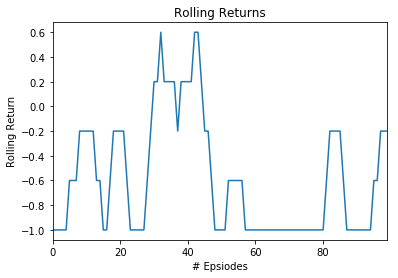

In [64]:
# Our fixed-weight agent
rolling_returns = run_loop(FixedAgent, num_episodes=100, record_every=5, rolling_return_frequency=5)
plot_rolling_returns(rolling_returns)

## Learning with Policy Gradients
Finally, let's give our agent some intelligence by making it learn from its experience in interacting with the environment. In order to learn, we need a loss function or *objective*. In RL, the objective is to maximise the expected episode return (rewards) by taking actions in the environment. The actions our agent takes are determined by the policy $\pi_\theta(a|s)$, which are in turn determined by the neural network parameters $\theta$. So, we want to find the neural network parameters $\theta$ that maximise 

$J(\theta) = \mathbb{E}_{\tau}[r(\tau)]$

**Note:** If the maths in the next section looks intimidating, feel free to skip over it, read the intuition and code and come back to it later! 


### The derivative of the objective
We now turn to our usual tool of stochastic gradient descent to optimise the objective, but there are two complications. Firstly, the term $\pi_\theta(a|s)$ represented by our neural network doesn't appear in the equation (or does it?). Secondly, how do we deal with the expectation?

The first thing is to realise that our trajectories $\tau$ depend on the policy $\pi_\theta(a|s)$ (**Question:** Why?) So we can (informally) write:

\begin{align}
J(\theta) &= \mathbb{E}_{\tau \sim \pi_\theta(\tau)}  [r(\tau)] & \\
&= \int \pi_\theta (\tau) r(\tau)d\tau  & (\text{Definition of expectation}) \\
\end{align}

Then the gradient is:

\begin{align}
\nabla_\theta J(\theta) &= \nabla_\theta \int \pi_\theta (\tau) r(\tau)d\tau & \\
&= \int \pi_\theta (\tau) \nabla_\theta log \pi_\theta (\tau) r(\tau)d\tau & (\text{"Log derivative trick"}) \\
&= \mathbb{E}_{\tau \sim \pi_\theta(\tau)}[\nabla_\theta log \pi_\theta (\tau) r(\tau)]
\end{align}

Finally, since we don't know the true distribution of $\tau$, we can approximate the expectation using a *monte-carlo* approximation, where the sample trajectories come from $N$ episodes of interaction with the environment. 

\begin{align}
\nabla_\theta J(\theta) &= \frac{1}{N} \sum_{i=1}^N \nabla_\theta log \pi_\theta (\tau_i) r(\tau_i)
\end{align}

Expanding this out (and considering that episode $i$ has $T_i$ steps) gives:

\begin{align}
\nabla_\theta J(\theta) &= \frac{1}{N} \sum_{i=1}^N (\sum_{t=1}^{T_i} \nabla_\theta log(\pi_\theta(a_{i,t} | s_{i, t})) \sum_{t=1}^{T_i} \gamma^t r_{i,t} )
\end{align}

We skipped a few steps in the maths here for brevity (see chapter 13 of [Sutton and Barto](https://drive.google.com/file/d/1xeUDVGWGUUv1-ccUMAZHJLej2C7aAFWY/view) for all the details if you're interested!). If the maths looks intimidating, don't worry! The important things to realise are the following:
* We define an objective $J(\theta)$ that is exactly what we want to do with RL, maximise the expected return.
* We can run our agent in the environment to generate *trajectories* for multiple episodes
* When an episode comes to an end and we know the return and trajectory, we can compute a term in (the Monte-carlo approximation to) the objective function. 
* We can use Tensorflow to compute the gradient of an individual term in the monte-carlo approximation and apply it to the parameters of our neural network. To do this, we define the *loss* to minimise as follows (where the sums can be represented by loops and we set $\gamma = 1$ for simplicity):

\begin{align}
L(\theta) &= -\sum_{t=1}^{T_i} log(\pi_\theta(a_{i,t} | s_{i, t})) \sum_{t=1}^{T_i} r_{i,t} 
\end{align}

The name "policy gradient" comes from the fact that we're directly taking the gradient of the policy, rather than the alternative, value-based RL, which uses iterative update rules to calculate the expected return assocated with a state. The particular flavour of policy gradient which uses the loss function above, along with the Monte-carlo approximation of the objective is known as the **REINFORCE** algorithm. 



Finally, we implement the REINFORCE algorithm to optimize the parameters of the neural network. The only things we're changing, compared to our FixedAgent are the ```__init__``` and ```end_episode``` methods, so we use *inheritance* again to automatically "copy" all the methods from ```FixedAgent``` and ```RandomAgent```. 

**Note:** ```ReinforceAgent``` indirectly inherits the methods from ```RandomAgent``` through ```FixedAgent``` (which directly inherits from ```RandomAgent```).  Both ```RandomAgent``` and ```FixedAgent``` have a ```policy``` method, but the one that gets "copied" to ```ReinforceAgent``` is the one from ```FixedAgent``` because it appeared later in the chain.

In [65]:
class ReinforceAgent(FixedAgent):
  
  # Override the initialization method because this agent also needs an optimizer
  # and a variable to track the step
  def __init__(self, actions, state_size, seed):
    super(ReinforceAgent, self).__init__(actions, state_size, seed)
    self._optimizer = tf.train.RMSPropOptimizer(learning_rate=0.001)  
    self._step_counter = tf.train.get_or_create_global_step()
  
  def end_episode(self, final_reward): 
    """At the end of an episode, we compute the loss for the episode and take a 
    step in parameter speace in the direction of the gradients."""
    
    # Compute the return (cumulative discounted reward) for the episode
    episode_return = sum(self._rewards) + final_reward  # Assuming \gamma = 1

    with tf.GradientTape() as tape:
      # Loop over the states and actions making up the episode trajectory
      loss = 0
      for state, action in zip(self._observed_states, self._taken_actions):  
        # Get the probabilities assigned to the actions given the state by the policy
        action_distribution = self.policy(state)  
        action_index = self._actions.index(action)
        # Get the log probability of the chosen action under the policy
        log_action = tf.log(action_distribution[action_index])
        # Add to the running total for the episode
        loss -= log_action * episode_return          # Add your baseline value for TASK 4 here. 

    # Compute the gradient of the loss with respect to the variables in the model
    grads = tape.gradient(loss, self._policy_network.variables) 
    
    # Use the optimizer to apply the gradient
    self._optimizer.apply_gradients(
        zip(grads, self._policy_network.variables), global_step=self._step_counter)
    
    return 'Loss: {}'.format(loss)

Notice that during the episode we run only the forward-pass of the policy network (inference). At the end of the episode, we replay the states that occured during the episode and run both the forward and backward pass of the policy network (notice the gradient tape!) because we can only compute the loss once we have the episode return at the end of the episode. If the policy network is very complex, this could be inefficient. In that case you could run both the forward an backward pass during the episode and store intermediate gradients/partial derivatives to use in the update at the end of the episode.

And finally we train our **REINFORCE** agent and plot the resulting rolling episode returns (over a window of 100 episodes).

t:  28%|██▊       | 274/990 [00:00<00:00, 2735.90it/s, now=None]

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


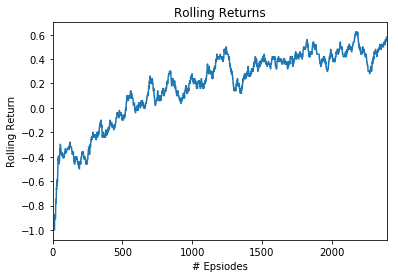

In [66]:
rolling_returns = run_loop(ReinforceAgent, num_episodes=2400, record_every=30)
plot_rolling_returns(rolling_returns)

## Your Tasks
### Task 1: Learning Objectives [ALL]
Review the learning objectives and ensure that you understand how the code in this practical relates to them. Ask your tutors if you don't understand anything!

### Task 2: Network Architecture [ALL]
Experiment with different network architectures and parameters and see how this affects the performance of the agent. What do you notice? Do you think the algorithm is sensitive to the network parameters?  

**HINT**: Modify the code for the policy network in the ```__init__``` method of the ```FixedAgent``` class. 

### Task 3: Seed Variance **[ALL]** 
Reveal and run the code in the cells below. This code will run the entire training procedure of the REINFORCE agent 10 times (using only 1000 episodes per run to save some time). It will then plot a chart that shows the mean of the rolling returns over the multiple runs along with an estimated *confidence interval* for the mean. You should notice that the confidence interval is fairly wide given that only the random seed is changing. This illustrates a problem with the REINFORCE algorithm: it has **high variance**. (It is however an **unbiased estimator** of the policy gradient!)

### Task 4: Variance Reduction with a Basline **[INTERMEDIATE]** 
Read about value functions and how to approximate them using *Monte-Carlo* methods in [Slides 5 to 7 Here](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/MC-TD.pdf). Then read slides [80, 84 and 85 here](http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture14.pdf). The goal of this task is to use a simple value function $V(s)$ to implement **REINFORCE with a Baseline**, where the loss function per episode changes to: 

\begin{align}
L(\theta) &= -\sum_{t=1}^{T_i} log(\pi_\theta(a_{i,t} | s_{i, t})) \sum_{t=1}^{T_i} [r_{i,t} - V(s_{i, t})]
\end{align}

To do this, add code to the ```end_episode``` method of the ```ReinforceAgent``` class to estimate the value function. Subtract the value estimate for the state from the episode return at each step in the loop that computes the log_action_sum. 

Re-run Task 3's code to plot the confidence interval around the mean episode returns to check what effect it has on the variance. 

**HINT**: You will need to *discretise* the state-space. We've provided a very crude function called ```state_to_buckets``` that you can use to do this, or implement your own! 

**Further Reading (Optional)**: See the section on how to introduce a baseline [here](https://danieltakeshi.github.io/2017/03/28/going-deeper-into-reinforcement-learning-fundamentals-of-policy-gradients/) for more details about how and why this works!

**Further Reading (Optional)**: This [blog post](https://flyyufelix.github.io/2017/10/12/dqn-vs-pg.html) contrasts policy gradient methods with an alternative value-based approach to RL called Deep Q-Networks. It also discusses some approaches to reducing the variance of the policy gradient estimator. 

### Task 5: Learning from pixels **[OPTIONAL]**
The agent we implemented in this practical uses a simple numerical representation of the state of the environment. In many cases such a representation would not be available. Change the run-loop to instead pass the array of pixel values to the agent. (which you can get by calling ```environment.getScreenRGB()```). Change the agent's policy network to cater for this image-representation of the state. 



### Task 6: Other games **[OPTIONAL]**
The PyGame Learning Environment (PLE) has [a number of games built-in](https://pygame-learning-environment.readthedocs.io/en/latest/user/games.html). Change the code in this practical to run on a different game and learn either from pixels or from the state representation provided by PLE. One interesting game you could try is FlappyBird! Remember to remove the reward overrides we set when trying a new game! 

## Additional Code for Task 3
This might take some time to run, continue reading for Task 4 and ask any questions you have while waiting!

In [67]:
all_rolling_returns = []

for i in range(10):
  rolling_returns = run_loop(ReinforceAgent, num_episodes=1000, record_every=25, seed=np.random.randint(100000))
  all_rolling_returns.append(rolling_returns)

plot_rolling_returns(np.array(all_rolling_returns))

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4

Moviepy - Done !
Moviepy - video ready __temp__.mp4


Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4

Moviepy - Done !
Moviepy - video ready __temp__.mp4


Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4

Moviepy - Done !
Moviepy - video ready __temp__.mp4


Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4

Moviepy - Done !
Moviepy - video ready __temp__.mp4


KeyboardInterrupt: 